# No Data Preparation

<!-- No Data Preparation: Let Khiops Work Its Magic on Raw Data -->

## Introduction

In machine learning, optimizing model performance often involves complex data preparation, manual feature engineering and hyper-parameter tuning. In real-world applications where data quality is imperfect and uncontrolled, the cost and effort of bringing data to a clean state can outweigh the commercial value derived. While standard AutoML solutions aim to simplify these processes, they often operate as global orchestrators, exploring various learning algorithms and data preparation techniques. While powerful, they are limited in their scalability as they always involve multiple iterations, and often the inner workings of the selected model remain a black box.

Khiops is not simply another tool or orchestrator of existing methods in the machine learning arsenal. It is built around an original formalism and dedicated optimization algorithms. Trained models are intrinsically **interpretable, robust and free of hyperparameters**. This means you don't need to run multiple iterations with different configurations (no grid search), nor struggle with data preparation through elaborate pipelines. With Khiops, you can process raw data directly and seamlessly, even if it comes from multiple tables (relational or multi-table data). 

In this notebook, we focus on Khiops' ability to process data in its rawest possible form, highlighting its strengths in automatic data preparation; other notebooks will look at other benefits such as interpretability, automated feature engineering (when dealing with multi-tables) and computational efficiency in large datasets.

### Purpose of the experiment

Our experiment starts with an "ideal" data set with no quality problems. We then add various types of defects common in real data: class-dependent missing values, labeling noise, outliers and class imbalance. This approach illustrates the strength of Khiops: its robustness and adaptability to changes in data quality, whereas other competing methods may require additional pre-processing steps to maintain their performance.

#### Experimental background

This study uses the Adult UCI dataset to compare Khiops to standard machine learning models, all evaluated using the same methodology. Our experiments cover the following steps:

- Working with the "ideal" dataset, 
- Adding class-dependent missing values (reflecting real-world scenarios where missing values are not randomly and uniformly distributed across classes),
- Adding noise and outliers,
- Adding class imbalance.

To keep the notebook concise, readable and educational, the pre-processing steps required for other methods are handled by pyCaret, a machine learning library that handles tasks such as missing value imputation and label encoding. Our experimental protocol guarantees a fair comparison. 

## Installation and set up

If you do not use our offical `khiops-notebook` Jupyter Docker image, you may have to install khiops locally using `conda`:

In [1]:
#!conda install -c khiops khiops

For the experiments, you also need some external libraries you can install via `pip`:

In [2]:
# Installation of external libraries
#!pip install matplotlib seaborn pycaret

We now import all the dependencies here:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from khiops.sklearn import KhiopsClassifier

from pycaret.classification import *

## Import and Preparation of Data

For this notebook, we use the "Adult" UCI standard Dataset. More details available [here][UCI-adult].

[UCI-adult]: https://archive.ics.uci.edu/dataset/2/adult

This dataset is also available on our [khiops-sample][khiops-sample] repository on Github.

[khiops-sample]:https://github.com/KhiopsML/khiops-samples/

In [4]:
# Load data directly from our GitHub
url = "https://raw.githubusercontent.com/KhiopsML/khiops-samples/1686433ec63549a741cec49604d7004bec6e1eeb/Adult/Adult.txt"

# Read the data into a Pandas DataFrame
df = pd.read_csv(url, delimiter='\t',index_col="Label")

# Display the first 10 records from the dataset
df.head(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
Label,,,,,,,,,,,,,,,
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,less
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,less
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,less
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,less
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,less
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,less
7,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,less
8,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,more
9,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,more


## Benchmark

pyCaret drives the benchmark, in order to maintain a consistent methodology across all models and simplifying the notebook. There is two different pyCaret setup:

- Khiops is trained using `preprocess=False` . Indeed, Khiops is able to work efficiently with objects like `string`, **eliminating the need for preliminary data preparation such as label encoding or imputation**. It contrasts sharply with traditional machine learning models, which require to make choices for data preprocessing.
- All other standard models are train with `preprocess=True`. We use pyCaret to prepare the data for these other models, leveling the playing field. 

It's important to note that **integrating Khiops into a pyCaret pipeline including data preparation would be counterproductive**. The pyCaret data preparation steps that benefit other models can actually degrade Khiops' performance, as it's designed to leverage the full detailed raw data (e.g. by exploiting the missing values distribution). We will demonstrate this in the final section of this notebook.

By default, pyCaret employes a stratified cross-validation. It's worth noting that one of Khiops' key advantages is its ability to perform robustly without the need for cross-validation (as it is hyperparameter-free and does not require data preprocessing). In real-world applications, a simple train-test split suffices for Khiops to learn an effective model, provided there is enough data.  **The 10-folds cross-validation is thus more of a formality to average the performance metrics but is unlikely to change the model.**



We use bar chart to compare all the models, so we create a dedicate function:

In [5]:
def plot_model_comparison(df, title):
    """
    Plot a bar chart comparing various metrics across different models.
    
    Parameters:
    - df: DataFrame containing the model metrics. Must have a 'Model' column and metric columns like 'Accuracy', 'AUC', etc.
    - title: The title for the plot.
    """
    # Filter the models based on a criterion if necessary (e.g., F1-score > 0.5)
    # df = df[df['F1'] > 0.5]

    # To ease visualization, sort and reshape the DataFrame
    df_plot = df.sort_values(by="Model").melt(id_vars=['Model'], var_name='Metric', value_name='Value')

    plt.figure(figsize=(14, 6))

    # Create a bar plot with Seaborn
    sns.barplot(x='Metric', y='Value', hue='Model', data=df_plot, palette="Set3")

    plt.title(title)
    plt.ylabel('Value')
    plt.xlabel('Metric')

    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

## Training on the clean Adult dataset 

We can start by comparing Khiops Classifier with others using the clean adult data set (i.e., before introducing missing values and other defects).

We prepare the data for modeling. To do this, we split the data into (X, y) where X contains the features (sepal length, width, etc.) and y contains the labels (the Class column). This is not necessary for pyCaret, but it will facilitate the continuation of our experiments.


In [6]:
# Drop the "class" column to create the feature set (X).
X = df.drop("class", axis=1)

In [7]:
# Extract the "class" column to create the target labels (y).
y = df["class"].map({'less': 0, 'more': 1})

In [8]:
# the pyCaret setup for the standard models:
setup(pd.concat([X, y], axis=1), target = 'class', session_id=123, verbose=False)
compare_models(include=["lr","lightgbm","gbc","ada","rf","lda","ridge","et","dt"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8743,0.9287,0.6557,0.7840,0.7139,0.6342,0.6385,0.4340
gbc,Gradient Boosting Classifier,0.8659,0.9210,0.5954,0.7927,0.6798,0.5972,0.6071,0.9950
ada,Ada Boost Classifier,0.8616,0.9159,0.6082,0.7657,0.6777,0.5911,0.5976,0.3440
rf,Random Forest Classifier,0.8551,0.9030,0.6186,0.7345,0.6713,0.5793,0.5830,0.5660
lda,Linear Discriminant Analysis,0.8416,0.8921,0.5582,0.7177,0.6278,0.5293,0.5361,0.1700
ridge,Ridge Classifier,0.8407,0.0000,0.5009,0.7510,0.6008,0.5063,0.5226,0.1040
et,Extra Trees Classifier,0.8354,0.8793,0.6038,0.6746,0.6371,0.5311,0.5326,0.6520
dt,Decision Tree Classifier,0.8135,0.7465,0.6183,0.6087,0.6133,0.4904,0.4906,0.2710
lr,Logistic Regression,0.7981,0.5749,0.2619,0.7131,0.3827,0.2918,0.3445,0.3850


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [9]:
# we store the pycaret results on a dedicated DataFrame
results_on_raw_data= pull()

In [10]:
# the pyCaret setup for Khiops:
setup(pd.concat([X, y], axis=1), target = 'class', session_id=123, verbose=False, preprocess=False)
compare_models(include=[KhiopsClassifier()])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,KhiopsClassifier,0.8701,0.9260,0.6208,0.7918,0.6957,0.6146,0.6222,25.7890


KhiopsClassifier(auto_sort=True, internal_sort=None, key=None, n_features=100,
                 n_pairs=0, n_trees=10, output_dir=None, verbose=False)

In [11]:
# we now store the Khiops results on our DataFrame 
results_on_raw_data = pd.concat([results_on_raw_data, pull()], ignore_index=True)
results_on_raw_data.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.8743,0.9287,0.6557,0.7840,0.7139,0.6342,0.6385,0.434
9,KhiopsClassifier,0.8701,0.9260,0.6208,0.7918,0.6957,0.6146,0.6222,25.789
1,Gradient Boosting Classifier,0.8659,0.9210,0.5954,0.7927,0.6798,0.5972,0.6071,0.995
2,Ada Boost Classifier,0.8616,0.9159,0.6082,0.7657,0.6777,0.5911,0.5976,0.344
3,Random Forest Classifier,0.8551,0.9030,0.6186,0.7345,0.6713,0.5793,0.5830,0.566
4,Linear Discriminant Analysis,0.8416,0.8921,0.5582,0.7177,0.6278,0.5293,0.5361,0.170
5,Ridge Classifier,0.8407,0.0000,0.5009,0.7510,0.6008,0.5063,0.5226,0.104
6,Extra Trees Classifier,0.8354,0.8793,0.6038,0.6746,0.6371,0.5311,0.5326,0.652
7,Decision Tree Classifier,0.8135,0.7465,0.6183,0.6087,0.6133,0.4904,0.4906,0.271
8,Logistic Regression,0.7981,0.5749,0.2619,0.7131,0.3827,0.2918,0.3445,0.385


We can finally show those results on a bar chart so that we won't focus uniquely on model ranks on the table:

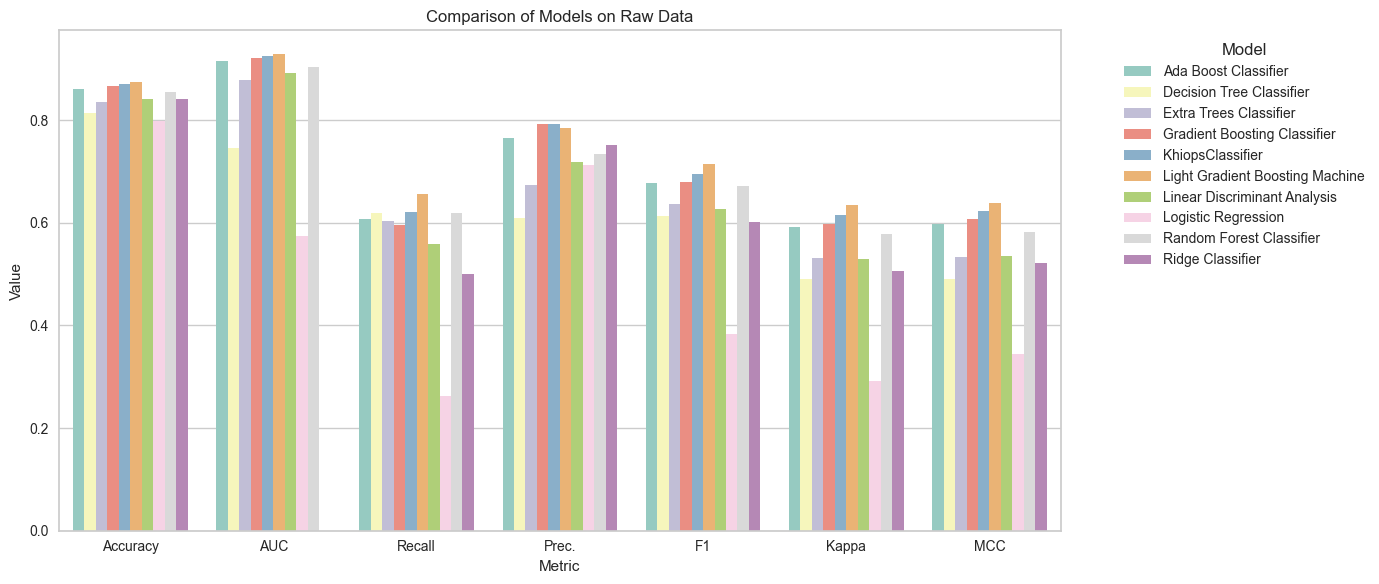

In [12]:
# We'll plot the results. We're excluding the computation time (TT in seconds) from the visualization, as its significance is minimal on small datasets.
plot_model_comparison(results_on_raw_data.drop('TT (Sec)',axis=1),'Comparison of Models on Raw Data')

## Introducing missing values

In real-world applications, missing values often do not occur entirely at random. Instead, the absence of value can be indicative of underlying patterns or conditions. For example, particular sub-categories may not be available for specific product categories, illustrating missingness dependent on other observed data. Alternatively, some targeted-class users may be reluctant to disclose specific information, reflecting missingness dependent on unobserved data. In these cases, the missing data itself becomes an additional source of information, carrying potentially significant implications for the problem at hand.

To emulate such complex patterns in realistic conditions, we will introduce Class-Based Missing Values into the dataset. The probability of a value being missing will be determined by its corresponding target class. We have chosen differentiating missing rates to accentuate the significance of the missing value pattern: a 20% missing data rate for instances belonging to class '0' and a 5% rate for those belonging to class '1'.

By focusing solely on Class-Based Missing Values, we aim to highlight the adaptability and power of Khiops in leveraging missing data patterns, as compared to other machine learning models that often require data imputation or other preparation steps to handle missing information effectively.

In [13]:
X_class_based_missing_values = X.copy()

# Percentage of missing values depending on the class
missing_rate_class_0 = 0.2  # 20% missing when class is 0
missing_rate_class_1 = 0.05  # 5% missing when class is 1

# Identify indices where class is 0
indices_class_0 = X_class_based_missing_values.index[y.loc[X_class_based_missing_values.index] == 0]

# Identify indices where class is 1
indices_class_1 = X_class_based_missing_values.index[y.loc[X_class_based_missing_values.index] == 1]

# Number of missing values for each class
N_0 = int(len(indices_class_0) * missing_rate_class_0)
N_1 = int(len(indices_class_1) * missing_rate_class_1)

# Iterate over feature columns
for col in X_class_based_missing_values.columns:

        # the column index (for the seed)
        col_index = X_class_based_missing_values.columns.get_loc(col)
    
        # Varying the seed by column index to distribute NaNs across different rows.
        np.random.seed(42 + col_index) ; random_indices_0 = np.random.choice(indices_class_0, N_0, replace=False)
        np.random.seed(42 + col_index) ; random_indices_1 = np.random.choice(indices_class_1, N_1, replace=False)
        
        # Introduce missing values
        X_class_based_missing_values.loc[random_indices_0, col] = np.nan
        X_class_based_missing_values.loc[random_indices_1, col] = np.nan

X_class_based_missing_values.head(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
Label,,,,,,,,,,,,,,
1,39.0,NaN,77516.0,Bachelors,NaN,Never-married,Adm-clerical,NaN,White,Male,2174.0,0.0,40.0,United-States
2,50.0,NaN,83311.0,Bachelors,13.0,Married-civ-spouse,NaN,NaN,White,Male,0.0,NaN,13.0,NaN
3,38.0,Private,215646.0,HS-grad,NaN,Divorced,Handlers-cleaners,Not-in-family,NaN,NaN,0.0,0.0,40.0,United-States
4,53.0,Private,234721.0,NaN,NaN,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,NaN,NaN
5,NaN,Private,NaN,Bachelors,NaN,Married-civ-spouse,NaN,Wife,Black,Female,0.0,0.0,40.0,Cuba
6,37.0,NaN,284582.0,NaN,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States
7,NaN,NaN,160187.0,9th,NaN,Married-spouse-absent,NaN,Not-in-family,Black,Female,NaN,0.0,NaN,Jamaica
8,52.0,Self-emp-not-inc,209642.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,NaN,Male,0.0,0.0,45.0,United-States
9,31.0,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States


In [14]:
setup(pd.concat([X_class_based_missing_values, y], axis=1), target = 'class', session_id=123, verbose = False)
compare_models(include=["lr","lightgbm","gbc","ada","rf","lda","ridge","et","dt"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9021,0.9526,0.7471,0.8274,0.7850,0.7219,0.7236,0.4020
gbc,Gradient Boosting Classifier,0.8890,0.9443,0.6577,0.8445,0.7393,0.6702,0.6787,0.9210
rf,Random Forest Classifier,0.8819,0.9318,0.6775,0.7989,0.7330,0.6579,0.6617,0.5420
ada,Ada Boost Classifier,0.8809,0.9349,0.6590,0.8082,0.7258,0.6507,0.6564,0.3300
et,Extra Trees Classifier,0.8593,0.9056,0.6486,0.7330,0.6880,0.5976,0.5996,0.6560
dt,Decision Tree Classifier,0.8390,0.7830,0.6751,0.6602,0.6674,0.5612,0.5614,0.1380
lda,Linear Discriminant Analysis,0.8387,0.8838,0.5232,0.7267,0.6082,0.5100,0.5210,0.1660
ridge,Ridge Classifier,0.8373,0.0000,0.4680,0.7602,0.5792,0.4854,0.5075,0.0960
lr,Logistic Regression,0.7999,0.5844,0.2523,0.7531,0.3729,0.2885,0.3520,0.1680


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [15]:
# we store the pycaret results on a dedicated DataFrame
results_class_based_missing_values= pull()

In [16]:
# the pyCaret setup for Khiops:
setup(pd.concat([X_class_based_missing_values, y], axis=1), target = 'class', session_id=123, verbose=False, preprocess=False)
compare_models(include=[KhiopsClassifier()])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,KhiopsClassifier,0.9222,0.9688,0.8059,0.8602,0.8321,0.7815,0.7823,26.0010


KhiopsClassifier(auto_sort=True, internal_sort=None, key=None, n_features=100,
                 n_pairs=0, n_trees=10, output_dir=None, verbose=False)

In [17]:
# we now store the Khiops results on our DataFrame 
results_class_based_missing_values = pd.concat([results_class_based_missing_values, pull()], ignore_index=True)
results_class_based_missing_values.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
9,KhiopsClassifier,0.9222,0.9688,0.8059,0.8602,0.8321,0.7815,0.7823,26.001
0,Light Gradient Boosting Machine,0.9021,0.9526,0.7471,0.8274,0.7850,0.7219,0.7236,0.402
1,Gradient Boosting Classifier,0.8890,0.9443,0.6577,0.8445,0.7393,0.6702,0.6787,0.921
2,Random Forest Classifier,0.8819,0.9318,0.6775,0.7989,0.7330,0.6579,0.6617,0.542
3,Ada Boost Classifier,0.8809,0.9349,0.6590,0.8082,0.7258,0.6507,0.6564,0.330
4,Extra Trees Classifier,0.8593,0.9056,0.6486,0.7330,0.6880,0.5976,0.5996,0.656
5,Decision Tree Classifier,0.8390,0.7830,0.6751,0.6602,0.6674,0.5612,0.5614,0.138
6,Linear Discriminant Analysis,0.8387,0.8838,0.5232,0.7267,0.6082,0.5100,0.5210,0.166
7,Ridge Classifier,0.8373,0.0000,0.4680,0.7602,0.5792,0.4854,0.5075,0.096
8,Logistic Regression,0.7999,0.5844,0.2523,0.7531,0.3729,0.2885,0.3520,0.168


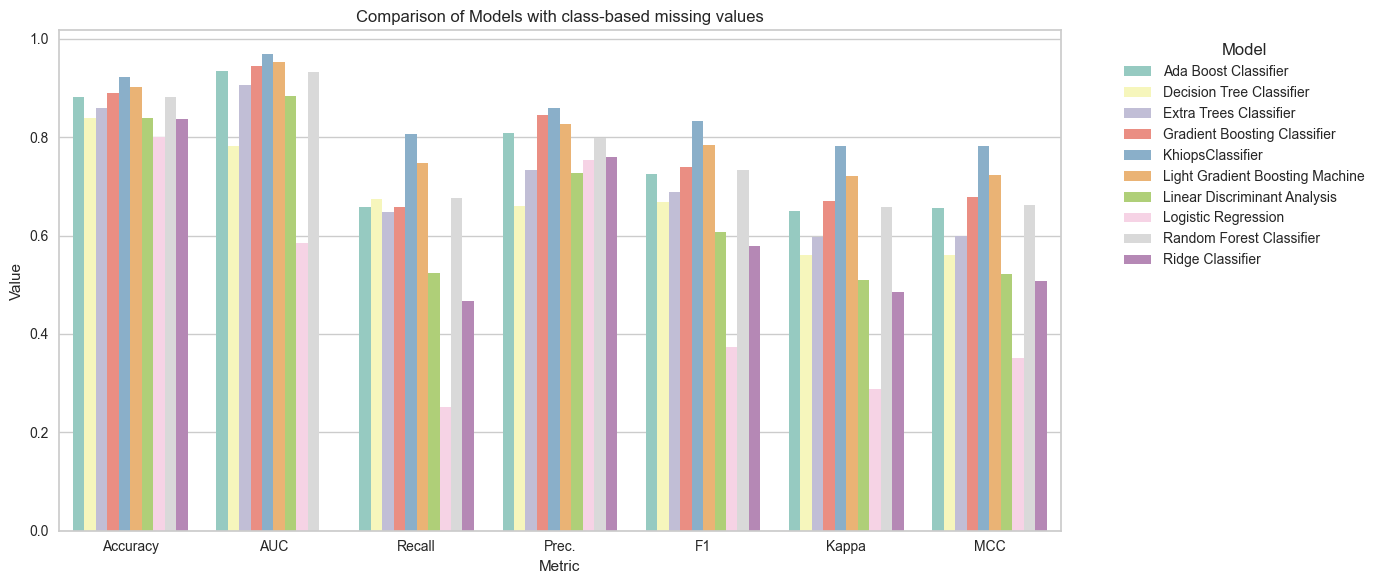

In [18]:
# We'll plot the results. We're excluding the computation time (TT in seconds) from the visualization, as its significance is minimal on small datasets.
plot_model_comparison(results_class_based_missing_values.drop('TT (Sec)',axis=1),'Comparison of Models with class-based missing values')

While the specific rates of missing values used in these experiments (20% for class '0' and 5% for class '1') may not be directly representative of real-world datasets, they serve to illustrate a crucial point: 

**Khiops outperformed other models in this experiment when the missing data is not random and carries informative weight about the target variable**. This shows the effectiveness of Khiops in leveraging the informational value of missing data, which is often not missing at random in real-world applications. Plus, **Khiops automatically takes advantage of the information without requiring additional manual effort**.


## Adding Noise and Outliers

Noise and outliers are almost inevitable and can significantly impact the performance of machine learning models. Noise can be defined as random variations that obscure patterns, while outliers are extreme values that deviate considerably from the other observations. In this section, we introduce noise and outliers to key columns to test how well Khiops and other standard models cope with such challenges.

For this experiment, we'll use the following arbitrary values:

- Noise is introduced as a normal distribution with a standard deviation set to 3.
- Outliers will be introduced in 10% of the instances and will be 30 times larger than the actual maximum value in the column.

It's important to note that while these values are not likely to mirror real-world distributions, they evaluate the robustness of the tested models. And when the pyCaret Data Preparation should prevent impact for standard models, this experiment focuses mainly on showing that Khiops behaves correctly when dealing with poor quality raw data.

In [19]:
X_noise_and_outliers = X_class_based_missing_values.copy()

# Introduce noise to 'age'
np.random.seed(42)
noise_age = np.random.normal(0, 3, len(X_noise_and_outliers))
X_noise_and_outliers['age'] = X_noise_and_outliers['age'] + np.round(noise_age).astype(int)

# Introduce noise to 'hours_per_week'
np.random.seed(43)
noise_hours_per_week = np.random.normal(0, 3, len(X_noise_and_outliers))
X_noise_and_outliers['hours_per_week'] = X_noise_and_outliers['hours_per_week'] + np.round(noise_hours_per_week).astype(int)

# Introduce outliers to 'age'
np.random.seed(42)
outlier_indices_age = np.random.choice(X_noise_and_outliers.index, int(0.1 * len(X_noise_and_outliers)), replace=False)
X_noise_and_outliers.loc[outlier_indices_age, 'age'] = X_noise_and_outliers['age'].max() * 30  # Setting to 30 times the max value

# Introduce outliers to 'hours_per_week'
np.random.seed(43)
outlier_indices_hours_per_week = np.random.choice(X_noise_and_outliers.index, int(0.1 * len(X_noise_and_outliers)), replace=False)
X_noise_and_outliers.loc[outlier_indices_hours_per_week, 'hours_per_week'] = X_noise_and_outliers['hours_per_week'].max() * 30  # Setting to 30 times the max value

# Introduce outliers to 'capital_gain'
np.random.seed(44)
outlier_indices_capital_gain = np.random.choice(X_noise_and_outliers.index, int(0.1 * len(X_noise_and_outliers)), replace=False)
X_noise_and_outliers.loc[outlier_indices_capital_gain, 'capital_gain'] = X_noise_and_outliers['capital_gain'].max() * 30  # Setting to 30 times the max value

X_noise_and_outliers.head(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
Label,,,,,,,,,,,,,,
1,40.0,NaN,77516.0,Bachelors,NaN,Never-married,Adm-clerical,NaN,White,Male,2999970.0,0.0,41.0,United-States
2,50.0,NaN,83311.0,Bachelors,13.0,Married-civ-spouse,NaN,NaN,White,Male,0.0,NaN,3210.0,NaN
3,40.0,Private,215646.0,HS-grad,NaN,Divorced,Handlers-cleaners,Not-in-family,NaN,NaN,0.0,0.0,39.0,United-States
4,58.0,Private,234721.0,NaN,NaN,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,NaN,NaN
5,2910.0,Private,NaN,Bachelors,NaN,Married-civ-spouse,NaN,Wife,Black,Female,0.0,0.0,43.0,Cuba
6,36.0,NaN,284582.0,NaN,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,39.0,United-States
7,NaN,NaN,160187.0,9th,NaN,Married-spouse-absent,NaN,Not-in-family,Black,Female,NaN,0.0,3210.0,Jamaica
8,54.0,Self-emp-not-inc,209642.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,NaN,Male,0.0,0.0,51.0,United-States
9,30.0,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,54.0,United-States


In [20]:
setup(pd.concat([X_noise_and_outliers, y], axis=1), target = 'class', session_id=123, verbose = False)
compare_models(include=["lr","lightgbm","gbc","ada","rf","lda","ridge","et","dt"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8947,0.9470,0.7267,0.8138,0.7676,0.6999,0.7019,0.4240
gbc,Gradient Boosting Classifier,0.8836,0.9387,0.6389,0.8364,0.7241,0.6520,0.6617,0.9840
rf,Random Forest Classifier,0.8760,0.9236,0.6533,0.7924,0.7159,0.6375,0.6425,0.5770
ada,Ada Boost Classifier,0.8710,0.9246,0.6313,0.7879,0.7007,0.6198,0.6261,0.3440
et,Extra Trees Classifier,0.8525,0.8971,0.6411,0.7139,0.6753,0.5803,0.5818,0.6980
lda,Linear Discriminant Analysis,0.8295,0.8644,0.4943,0.7050,0.5810,0.4781,0.4900,0.1720
ridge,Ridge Classifier,0.8266,0.0000,0.4359,0.7312,0.5460,0.4473,0.4702,0.1110
dt,Decision Tree Classifier,0.8174,0.7531,0.6299,0.6162,0.6228,0.5024,0.5026,0.1450
lr,Logistic Regression,0.7656,0.5461,0.0633,0.5967,0.1144,0.0719,0.1351,0.1810


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [21]:
# we store the pycaret results on a dedicated DataFrame
results_noise_and_outliers = pull()

In [22]:
# the pyCaret setup for Khiops:
setup(pd.concat([X_noise_and_outliers, y], axis=1), target = 'class', session_id=123, verbose=False, preprocess=False)
compare_models(include=[KhiopsClassifier()])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,KhiopsClassifier,0.9182,0.9660,0.7928,0.8551,0.8227,0.7696,0.7706,25.3690


KhiopsClassifier(auto_sort=True, internal_sort=None, key=None, n_features=100,
                 n_pairs=0, n_trees=10, output_dir=None, verbose=False)

In [23]:
# we now store the Khiops results on our DataFrame 
results_noise_and_outliers = pd.concat([results_noise_and_outliers, pull()], ignore_index=True)
results_noise_and_outliers.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
9,KhiopsClassifier,0.9182,0.9660,0.7928,0.8551,0.8227,0.7696,0.7706,25.369
0,Light Gradient Boosting Machine,0.8947,0.9470,0.7267,0.8138,0.7676,0.6999,0.7019,0.424
1,Gradient Boosting Classifier,0.8836,0.9387,0.6389,0.8364,0.7241,0.6520,0.6617,0.984
2,Random Forest Classifier,0.8760,0.9236,0.6533,0.7924,0.7159,0.6375,0.6425,0.577
3,Ada Boost Classifier,0.8710,0.9246,0.6313,0.7879,0.7007,0.6198,0.6261,0.344
4,Extra Trees Classifier,0.8525,0.8971,0.6411,0.7139,0.6753,0.5803,0.5818,0.698
5,Linear Discriminant Analysis,0.8295,0.8644,0.4943,0.7050,0.5810,0.4781,0.4900,0.172
6,Ridge Classifier,0.8266,0.0000,0.4359,0.7312,0.5460,0.4473,0.4702,0.111
7,Decision Tree Classifier,0.8174,0.7531,0.6299,0.6162,0.6228,0.5024,0.5026,0.145
8,Logistic Regression,0.7656,0.5461,0.0633,0.5967,0.1144,0.0719,0.1351,0.181


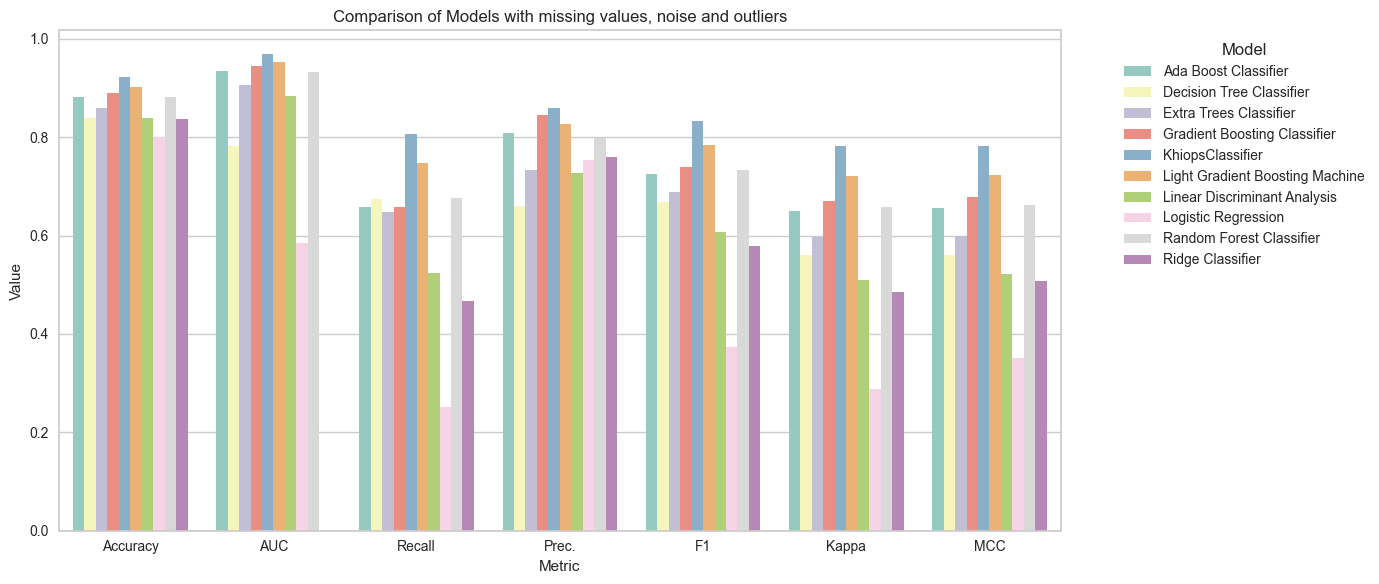

In [24]:
# We'll plot the results. We're excluding the computation time (TT in seconds) from the visualization, as its significance is minimal on small datasets.
plot_model_comparison(results_class_based_missing_values.drop('TT (Sec)',axis=1),'Comparison of Models with missing values, noise and outliers')

## Adding High Class Imbalance

The class distribution is often highly unbalanced in many domains, like fraud detection, healthcare, and anomaly detection. In these situations, one class is significantly underrepresented. This imbalance can be challenging for standard machine learning algorithms, which often assume an approximately equal distribution of classes. If not properly managed, the class imbalance can result in misleadingly high accuracy rates and poor identification of the minority class, which is often the class of most interest. This section will explore the impact of highly imbalanced class distribution on model performance (with only 1% instances of the class '1').

In [25]:
# Identify indices of 0 and 1 classes
indices_majority = np.where(y == 0)[0]
indices_minority = np.where(y == 1)[0]

# Randomly sample 3% of the 1 class
np.random.seed(42)
random_indices_minority = np.random.choice(indices_minority, 
                                            int(0.03 * len(indices_minority)),
                                            replace=False)

# Concatenate the indices of the 0 class with the downsampled indices of the 1 class
final_indices = np.concatenate([indices_majority, random_indices_minority])

# Create the imbalanced feature matrix and target vector
X_unbalanced = X_noise_and_outliers.iloc[final_indices, :]
y_unbalanced = y.iloc[final_indices]

In [26]:
# we print the number of instances per class, showing the high imbalance
y_unbalanced.value_counts()

0    37155
1      350
Name: class, dtype: int64

In [27]:
setup(pd.concat([X_unbalanced, y_unbalanced], axis=1), target = 'class', session_id=123, verbose = False)
compare_models(include=["lr","lightgbm","gbc","ada","rf","lda","ridge","et","dt"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9920,0.9702,0.2787,0.6759,0.3882,0.3850,0.4266,0.2790
gbc,Gradient Boosting Classifier,0.9919,0.9786,0.2542,0.6532,0.3631,0.3599,0.4023,0.7170
lightgbm,Light Gradient Boosting Machine,0.9915,0.9737,0.2910,0.5869,0.3847,0.3811,0.4070,0.3800
rf,Random Forest Classifier,0.9911,0.9252,0.0822,0.6500,0.1451,0.1434,0.2274,0.2510
lr,Logistic Regression,0.9907,0.4910,0.0000,0.0000,0.0000,0.0000,0.0000,0.1600
ridge,Ridge Classifier,0.9907,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0780
et,Extra Trees Classifier,0.9904,0.8492,0.1188,0.4320,0.1826,0.1795,0.2197,0.3000
dt,Decision Tree Classifier,0.9856,0.6352,0.2782,0.2639,0.2679,0.2607,0.2623,0.0930
lda,Linear Discriminant Analysis,0.9824,0.8734,0.1887,0.1528,0.1681,0.1594,0.1606,0.1280


AdaBoostClassifier(algorithm='SAMME.R', base_estimator='deprecated',
                   estimator=None, learning_rate=1.0, n_estimators=50,
                   random_state=123)

In [28]:
# we store the pycaret results on a dedicated DataFrame
results_unbalanced = pull()

In [29]:
# the pyCaret setup for Khiops:
setup(pd.concat([X_unbalanced, y_unbalanced], axis=1), target = 'class', session_id=123, verbose=False, preprocess=False)
compare_models(include=[KhiopsClassifier()])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,KhiopsClassifier,0.9931,0.9849,0.3395,0.8267,0.4722,0.4695,0.5210,24.9410


KhiopsClassifier(auto_sort=True, internal_sort=None, key=None, n_features=100,
                 n_pairs=0, n_trees=10, output_dir=None, verbose=False)

In [30]:
# we now store the Khiops results on our DataFrame 
results_unbalanced = pd.concat([results_unbalanced, pull()], ignore_index=True)
results_unbalanced.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
9,KhiopsClassifier,0.9931,0.9849,0.3395,0.8267,0.4722,0.4695,0.5210,24.941
0,Ada Boost Classifier,0.9920,0.9702,0.2787,0.6759,0.3882,0.3850,0.4266,0.279
1,Gradient Boosting Classifier,0.9919,0.9786,0.2542,0.6532,0.3631,0.3599,0.4023,0.717
2,Light Gradient Boosting Machine,0.9915,0.9737,0.2910,0.5869,0.3847,0.3811,0.4070,0.380
3,Random Forest Classifier,0.9911,0.9252,0.0822,0.6500,0.1451,0.1434,0.2274,0.251
4,Logistic Regression,0.9907,0.4910,0.0000,0.0000,0.0000,0.0000,0.0000,0.160
5,Ridge Classifier,0.9907,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.078
6,Extra Trees Classifier,0.9904,0.8492,0.1188,0.4320,0.1826,0.1795,0.2197,0.300
7,Decision Tree Classifier,0.9856,0.6352,0.2782,0.2639,0.2679,0.2607,0.2623,0.093
8,Linear Discriminant Analysis,0.9824,0.8734,0.1887,0.1528,0.1681,0.1594,0.1606,0.128


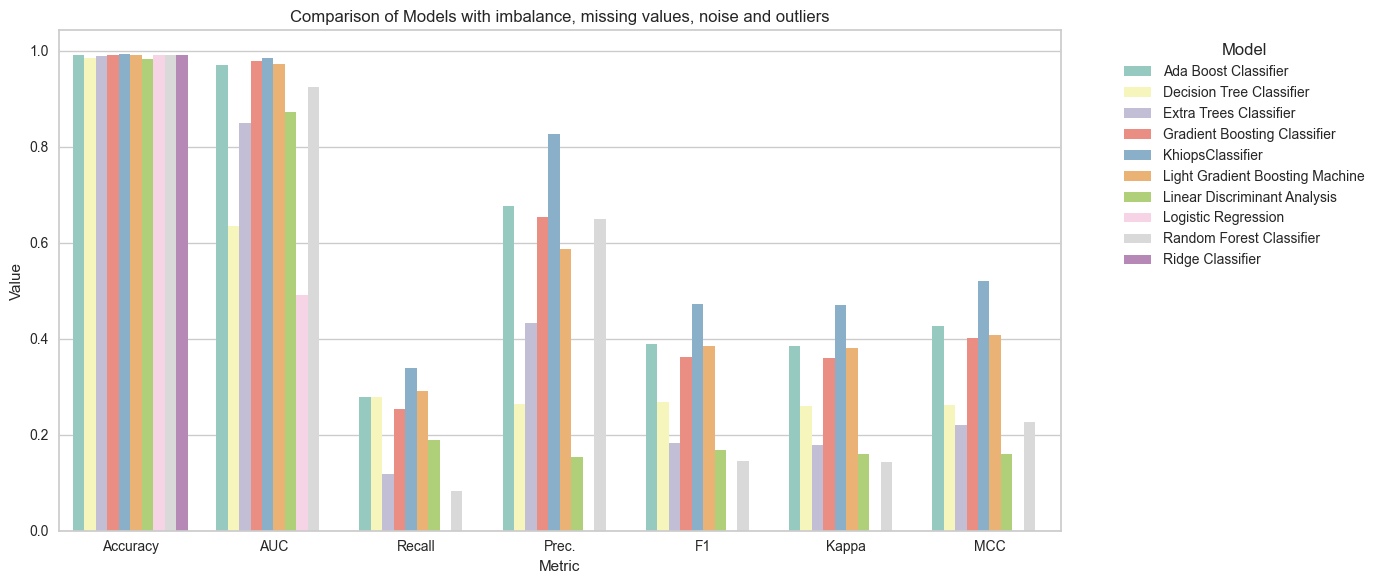

In [31]:
# We'll plot the results. We're excluding the computation time (TT in seconds) from the visualization, as its significance is minimal on small datasets.
plot_model_comparison(results_unbalanced.drop('TT (Sec)',axis=1),'Comparison of Models with imbalance, missing values, noise and outliers')

Khiops' ability to efficiently process raw, uncleaned data saves you valuable time, for a better understanding :

- business needs
- the data collected and its biases
- the methodology to be implemented 
- trained models and their interpretation...

In summary, the efficiency of Khiops in dealing with raw data frees you to concentrate on the core issues, enabling a more effective and targeted approach to problem-solving.

## Raw vs. Prepared: How Khiops Challenges Conventional Data Preparation

In machine learning, data preparation is often seen as an essential step to improve the performance of models. This common wisdom, however, doesn't always hold true, especially regarding Khiops. Unlike other models requiring intricate data preprocessing, Khiops excels when fed raw, unaltered data. In this section, we'll test this unique characteristic of Khiops. We'll use PyCaret for its data preparation pipelines as a contrasting framework. Our experiment compares the performance of Khiops on raw data against its performance within a data preparation pipeline. The aim is not to disparage PyCaret (it's a great library actually!) but to highlight that what is generally beneficial for most models can be counterproductive for Khiops. 

In [32]:
setup(pd.concat([X_class_based_missing_values, y], axis=1), target = 'class', session_id=123, verbose=False)
compare_models(include=[KhiopsClassifier()])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,KhiopsClassifier,0.8974,0.9517,0.7286,0.8225,0.7726,0.7066,0.7089,47.4880


KhiopsClassifier(auto_sort=True, internal_sort=None, key=None, n_features=100,
                 n_pairs=0, n_trees=10, output_dir=None, verbose=False)

In [33]:
results_Khiops_raw_vs_data_prep = pull()
results_Khiops_raw_vs_data_prep['Model'].replace({
    'KhiopsClassifier': 'Khiops on prepared Data',
    }, inplace=True)

In [34]:
setup(pd.concat([X_class_based_missing_values, y], axis=1), target = 'class', session_id=123, preprocess=False, verbose=False)
compare_models(include=[KhiopsClassifier()])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,KhiopsClassifier,0.9222,0.9688,0.8059,0.8602,0.8321,0.7815,0.7823,25.4620


KhiopsClassifier(auto_sort=True, internal_sort=None, key=None, n_features=100,
                 n_pairs=0, n_trees=10, output_dir=None, verbose=False)

In [35]:
results_Khiops_raw_vs_data_prep = pd.concat([results_Khiops_raw_vs_data_prep, pull()], ignore_index=True)
results_Khiops_raw_vs_data_prep['Model'].replace({
    'KhiopsClassifier': 'Khiops on Raw Data',
    }, inplace=True)
results_Khiops_raw_vs_data_prep.sort_values(by="Accuracy",ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
1,Khiops on Raw Data,0.9222,0.9688,0.8059,0.8602,0.8321,0.7815,0.7823,25.462
0,Khiops on prepared Data,0.8974,0.9517,0.7286,0.8225,0.7726,0.7066,0.7089,47.488


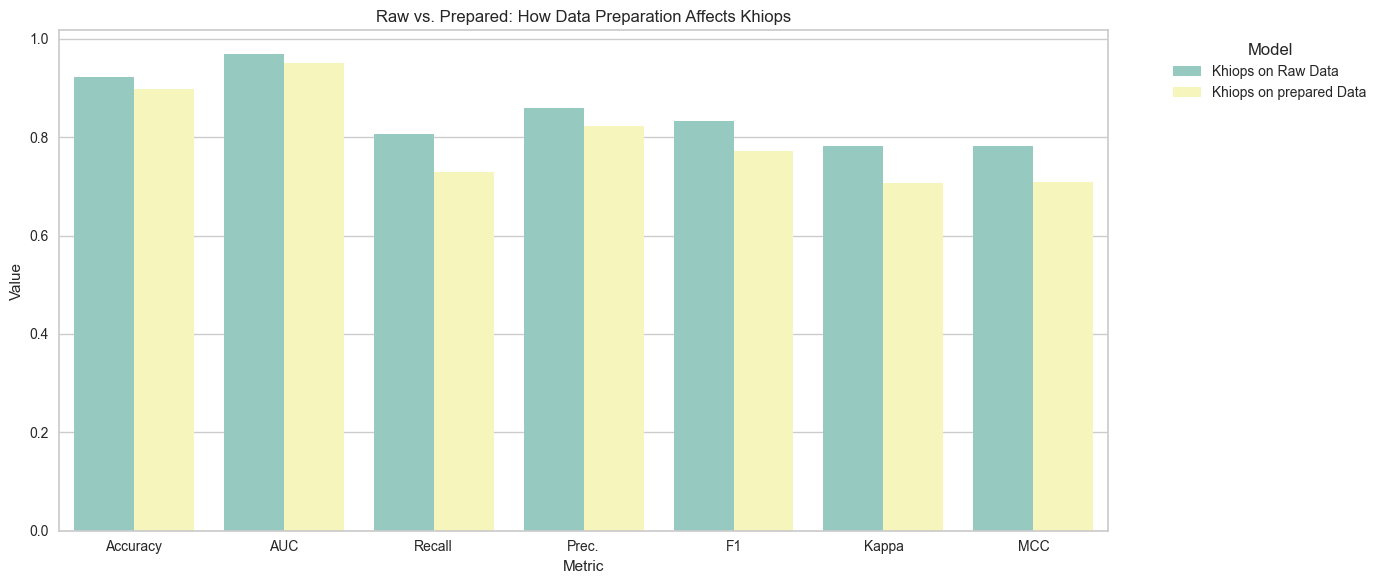

In [37]:
plot_model_comparison(results_Khiops_raw_vs_data_prep.drop('TT (Sec)',axis=1),'Raw vs. Prepared: How Data Preparation Affects Khiops')